# Playground

In [186]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/MyDrive/generative-models-for-phenotypic-profiling')
%cd /content/gdrive/MyDrive/generative-models-for-phenotypic-profiling
%pwd

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/generative-models-for-phenotypic-profiling


'/content/gdrive/MyDrive/generative-models-for-phenotypic-profiling'

In [187]:
%matplotlib inline
import matplotlib.pyplot as plt

from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader, Dataset

from gmfpp.utils.data_preparation import *
from gmfpp.utils.data_transformers import *
from gmfpp.utils.plotting import *

from gmfpp.models.ReparameterizedDiagonalGaussian import *
from gmfpp.models.CytoVariationalAutoencoder import *
from gmfpp.models.VariationalAutoencoder import *
from gmfpp.models.ConvVariationalAutoencoder import *
from gmfpp.models.VariationalInference import *

In [188]:
def constant_seed(seed: int = 0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

In [189]:
constant_seed()

In [190]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load data

In [191]:
data_root = "/content/gdrive/MyDrive/generative-models-for-phenotypic-profiling/data/two_from_each_moa/"
metadata_all = read_metadata(data_root + "metadata.csv")

mapping = get_MOA_mappings(metadata_all)

metadata = read_metadata(data_root + "metadata.csv")

metadata = shuffle_metadata(metadata)
metadata_train_all, metadata_test = split_metadata(metadata, split_fraction = .90)
metadata_train, metadata_validation = split_metadata(metadata_train_all, split_fraction = .90)

relative_path = get_relative_image_paths(metadata)
image_paths = [data_root + path for path in relative_path]
images = load_images(image_paths)

In [192]:
len(images)

26

In [193]:
images[1].shape

(68, 68, 3)

## plot using img_saturate() function

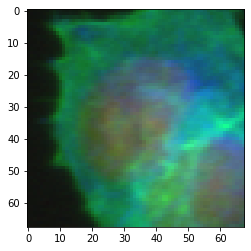

In [194]:
def img_saturate(img):
    return img / np.max(img)

plt.imshow(img_saturate(images[1]))

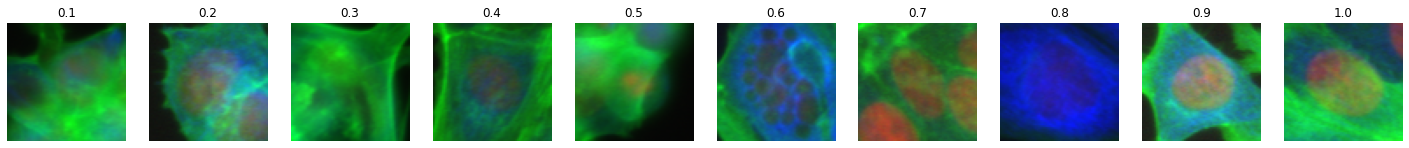

In [196]:
# fake cosine similarity numbers
cp = []
for i in range(10):
  cp.append(0.1+0.1*i)

# create figure
fig = plt.figure(figsize=(25, 10))

# setting values to rows and column variables
rows = 1
columns = len(imgs_plot)

# Adds a subplot at the 1st position

for i in range(columns):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img_saturate(images[i]))
  plt.axis('off')
  plt.title(round(cp[i],2))

## Normalize data

In [104]:
images = prepare_raw_images(images)
normalize_channels_inplace(images)
print(images.shape)

torch.Size([26, 3, 68, 68])


In [106]:
channel_first = view_channel_dim_first(images)
for i in range(channel_first.shape[0]):
    channel = channel_first[i]
    print("channel {} interval: [{:.2f}; {:.2f}]".format(i, torch.min(channel), torch.max(channel)))

channel 0 interval: [0.02; 1.00]
channel 1 interval: [0.01; 1.00]
channel 2 interval: [0.01; 1.00]


## Prepare datasets

In [107]:
class SingleCellDataset(Dataset):
    
    def __init__(self, metadata: pd.DataFrame, images: torch.Tensor, label_to_id: Dict[str, int]):
        self.metadata = metadata
        self.label_to_id = label_to_id
        self.images = images
        
    def __len__(self):
        return self.metadata.shape[0]

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        
        image_id = row["Single_Cell_Image_Id"]
        image = self.images[image_id]
        
        label_name = row["moa"]
        label = self.label_to_id[label_name]
        
        return image, label

In [108]:
train_set = SingleCellDataset(metadata_train, images, mapping)
validation_set = SingleCellDataset(metadata_validation, images, mapping)
test_set = SingleCellDataset(metadata_test, images, mapping)

In [109]:
len(train_set)

22

In [113]:
images[1].shape

torch.Size([3, 68, 68])

# NOTE: the same pictures looks a lot darker when normalised using normalize_channels_inplace()

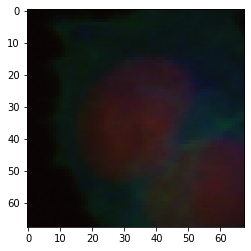

In [115]:
plt.imshow(torch.permute(images[1], (1, 2, 0)))

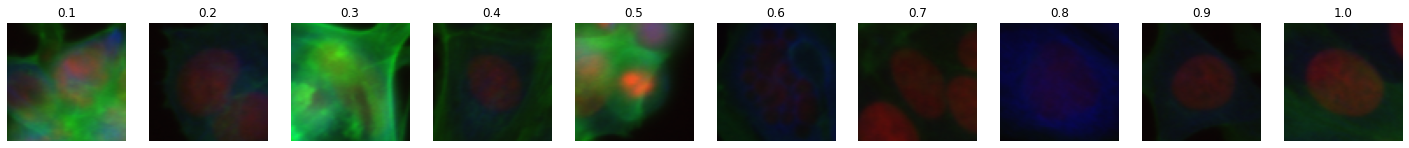

In [185]:
# fake cosine similarity numbers
cp = []
for i in range(10):
  cp.append(0.1+0.1*i)

# create figure
fig = plt.figure(figsize=(25, 10))

# setting values to rows and column variables
rows = 1
columns = len(imgs_plot)

# Adds a subplot at the 1st position

for i in range(columns):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(torch.permute(images[i], (1, 2, 0)))
  plt.axis('off')
  plt.title(round(cp[i],2))


# code from here: https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/